In [1]:
import qutip as qp
import matplotlib.pyplot as plt
import numpy as np
import torch as t

C:\Users\jv97\anaconda3\lib\site-packages\qutip\__init__.py:61: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.15.
  .format(_cy_require, _Cython.__version__)


Qutip solution to spin precession:

In [3]:
basi = [qp.basis(2,i) for i in range(2)]
sig = [[basi[i] * basi[j].dag() for i in range(2)] for j in range(2)]

Gamma = 3/4

H0 = sig[0][0] - sig[1][1] + Gamma*(sig[0][1] + sig[1][0])

#psi0 = 1/np.sqrt(2)*(basi[0]+basi[1])
psi0 = basi[0]

T=5
n_steps = 200
tlist = np.linspace(0,T,n_steps)

In [4]:
output = qp.mesolve(H0,psi0,tlist)

In [5]:
projection = [(psi0.dag()*state).norm() for state in output.states]

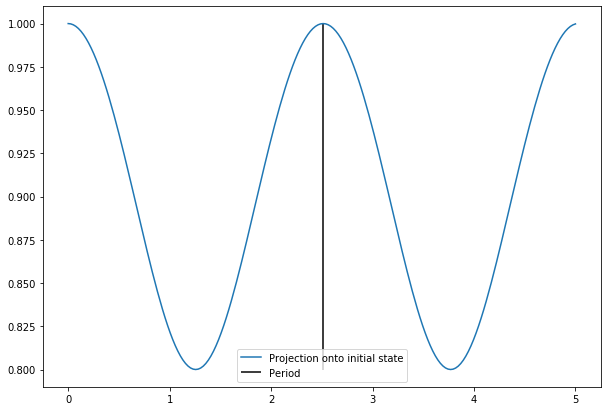

In [6]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(tlist,projection,label='Projection onto initial state')
ax.vlines(np.pi/np.sqrt(1+Gamma**2),0.8,1,label='Period')
ax.legend()

Try to accomplish the same with the Trotter approximation

In [7]:
psi0 = np.array([[1],[0]])
H0 = np.array([[1,Gamma],[Gamma,-1]])
Id = np.array([[1,0],[0,1]])

U = [np.linalg.matrix_power(Id - 1j*T/n_steps*H0,n) for n in range(n_steps)]
evolution = [np.matmul(u,psi0) for u in U]

In [8]:
projection = [np.abs(np.matmul(psi0.T,state)).item() for state in evolution]

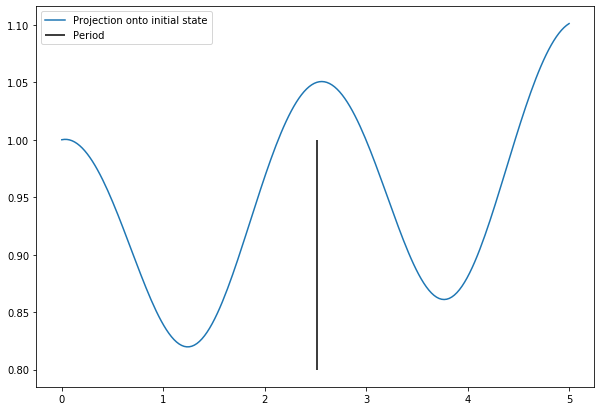

In [9]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(tlist,projection,label='Projection onto initial state')
ax.vlines(np.pi/np.sqrt(1+Gamma**2),0.8,1,label='Period')
ax.legend()

Ie. the approach
$$e^{-iH_0\Delta t} \sim 1 -iH_0 \Delta t $$
is non-unitary which results in a drift in the amplitude

# So:

In [10]:
psi0 = np.array([[1],[0]])
H0 = np.array([[1,Gamma],[Gamma,-1]])
# Id = np.array([[1,0],[0,1]])

from scipy.linalg import expm

U = [np.linalg.matrix_power(expm(-1j*T/n_steps*H0),n) for n in range(n_steps)]
evolution = [np.matmul(u,psi0) for u in U]

In [11]:
projection = [np.abs(np.matmul(psi0.T,state)).item() for state in evolution]

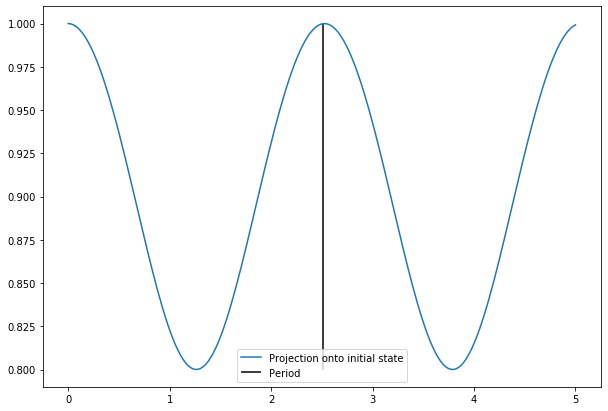

In [12]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(tlist,projection,label='Projection onto initial state')
ax.vlines(np.pi/np.sqrt(1+Gamma**2),0.8,1,label='Period')
ax.legend()

See if the same is possible in the pytorch framework, such that it's possible to autograd

In [13]:
####
#Investigation of whether pytorch can handle imaginary numbers. (It can)
####

z = 2j
tensor = t.tensor([z], requires_grad=True)
output = 2*tensor

output.backward()
tensor.grad

tensor([2.+0.j])

In [14]:
t.__version__

'1.11.0'

In [15]:
psi0 = t.tensor([[1+ 0j],[0]])
H0 = t.tensor([[1,Gamma],[Gamma,-1]],requires_grad=True)
# Id = t.tensor([[1,0],[0,1]])

U = [t.matrix_power(t.matrix_exp(-1j*T/n_steps*H0),n) for n in range(n_steps)]
evolution = [t.matmul(u,psi0) for u in U]

In [22]:
projection = [t.abs(t.matmul(psi0.T,state)).squeeze() for state in evolution]

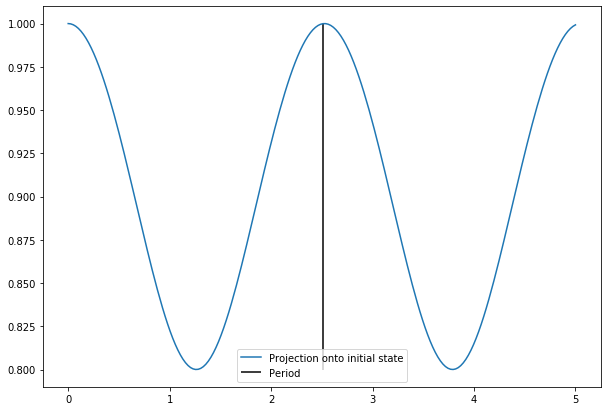

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(tlist,projection,label='Projection onto initial state')
ax.vlines(np.pi/np.sqrt(1+Gamma**2),0.8,1,label='Period')
ax.legend()

In [26]:
projection[100].backward()

In [28]:
H0.grad

tensor([[ 0.0060,  0.0044],
        [ 0.0044, -0.0060]])

Construed example:

Find direction and strength of magnetic field to get an initial state into (-z) eigenstate in time T

Firstly, how to use an optimizer:

In [33]:
parameter = t.nn.parameter.Parameter(t.tensor([1+0j]))
target = t.tensor([5+0j])

optimizer = t.optim.Adam([parameter],lr=1e-3)

loss = t.abs(target-parameter)
while loss >=0.1:
    optimizer.zero_grad()
    loss = t.abs(target-parameter)
    loss.backward()
    optimizer.step()

In [34]:
parameter

Parameter containing:
tensor([4.9018+0.j], requires_grad=True)

# So:

In [44]:
sig_x = t.tensor([[0j,1],
                  [1,0]])
sig_y = t.tensor([[0,-1j],
                  [1j,0]])
sig_z = t.tensor([[1,0],
                  [0j,-1]])

In [47]:
loss

tensor(0.9589, grad_fn=<SqueezeBackward0>)

In [75]:
B = t.nn.parameter.Parameter(t.tensor([0,0.001,1.]))

Psi0 = t.tensor([[0.9],[0.1+0j]])/np.sqrt(0.9**2+0.1**2)
Psi_target = t.tensor([[0j],[1]])

T=5
n_steps = 200

def evolve(B):
    H = B[0]*sig_x + B[1]*sig_y + B[2]*sig_z
    U = t.matrix_power(t.matrix_exp(-1j*T/n_steps*H),n_steps)
    return t.matmul(U,psi0)

PsiT = evolve(B)

def loss_func(PsiT):
    return 1 - t.abs(t.matmul(t.adjoint(Psi_target),PsiT)).squeeze()

loss = loss_func(PsiT)
optimizer = t.optim.Adam([B],lr=1e-3)

N = 0
while loss >=0.01 and N<=10000:
    optimizer.zero_grad()
    PsiT = evolve(B)
    loss = loss_func(PsiT)
    loss.backward()
    optimizer.step()
    N+=1
print(N)

728


In [78]:
H = B[0]*sig_x + B[1]*sig_y + B[2]*sig_z
U = [t.matrix_power(t.matrix_exp(-1j*T/n_steps*H),n) for n in range(n_steps)]
evolution = [t.matmul(u,psi0) for u in U]
projection = [t.abs(t.matmul(t.adjoint(Psi_target),state)).item() for state in evolution]

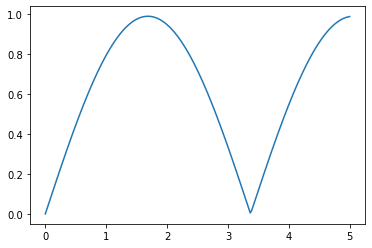

In [79]:
fig, ax = plt.subplots()

ax.plot(tlist,projection)